In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/dataset.zip

In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

In [6]:
data_transforms = {
    "train": transforms.Compose([
        # transforms.RandomResizedCrop(225),
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(250),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        # transforms.Resize(250),
        transforms.CenterCrop(250),
        # transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        # transforms.Resize(250),
        # transforms.CenterCrop(224),
        # transforms.Resize(200),
        transforms.CenterCrop(250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]

batch_size = 8
shuffle = True
num_workers = 0

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda', index=0)

In [10]:
!pip install efficientnet_pytorch

In [117]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b7')
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [118]:
# Freeze model weights
for param in model.parameters():
  param.requires_grad = False

In [119]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)

In [125]:
class_names = ["merger", "noninteracting"]

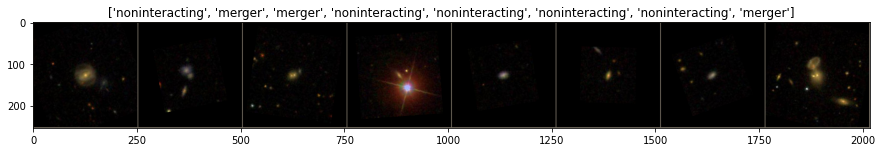

In [126]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [127]:
merger_count = 0
noninteracting_count = 0

for sample in dataloaders["train"].dataset.samples:
  if "merger" in sample[0]:
    merger_count += 1
  elif "noninteracting" in sample[0]:
    noninteracting_count += 1
print(merger_count)
print(noninteracting_count)

3003
5000


In [129]:
def train_model(model, criterion, optimizer, max_epochs_no_improve=5, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs_no_improve = 0  # For early stopping

    valid_loss_min = np.Inf
    valid_max_acc = 0.0

    # save_file_name = f"{epoch}.pt"

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =="train":
              train_losses.append(epoch_loss)
            elif phase == "val":
              valid_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == "valid" and (epoch_loss < valid_loss_min):
              torch.save(model.state_dict(), f"{epoch}.pt")
              # Track improvement
              epochs_no_improve = 0
              valid_loss_min = epoch_loss
              best_epoch = epoch
            elif phase == "valid" and (epoch_loss >= valid_loss_min):
              epochs_no_improve += 1
              if epochs_no_improve >= max_epochs_no_improve:
                model.load_state_dict(torch.load(f"{epoch}.pt"))
                # Attach the optimizer
                model.optimizer = optimizer

                return model, train_losses, valid_losses


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

In [130]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [131]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20)  # After every 20 epochs, decrease the lr by `gamma` (= 0.1 by default)

epochs = 50

In [132]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

63,792,082 total parameters.
5,122 training parameters.


In [133]:
model = model.to(device)

In [ ]:
model_conv, train_losses, valid_losses = train_model(model, criterion, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch 0/49
----------
train Loss: 1.1617 Acc: 0.5513
val Loss: 1.0064 Acc: 0.6234

Epoch 1/49
----------
train Loss: 1.3539 Acc: 0.5635
val Loss: 1.0388 Acc: 0.4931

Epoch 2/49
----------
train Loss: 1.3529 Acc: 0.5600
val Loss: 1.0989 Acc: 0.6257

Epoch 3/49
----------
train Loss: 1.3405 Acc: 0.5670
val Loss: 1.0880 Acc: 0.6224

Epoch 4/49
----------
train Loss: 1.4529 Acc: 0.5575
val Loss: 0.8738 Acc: 0.6269

Epoch 5/49
----------
train Loss: 1.3637 Acc: 0.5580
val Loss: 0.8400 Acc: 0.6262

Epoch 6/49
----------
train Loss: 1.5021 Acc: 0.5473
val Loss: 1.2754 Acc: 0.6252

Epoch 7/49
----------
train Loss: 1.4398 Acc: 0.5570
val Loss: 1.2767 Acc: 0.6252

Epoch 8/49
----------
train Loss: 1.4006 Acc: 0.5607
val Loss: 0.6603 Acc: 0.6252

Epoch 9/49
----------
train Loss: 1.3959 Acc: 0.5520
val Loss: 1.1923 Acc: 0.6202

Epoch 10/49
----------


In [99]:
type(model)

efficientnet_pytorch.model.EfficientNet